In [ ]:
from tensorflow import keras
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Activation
from keras.layers.convolutional import Conv2D, ZeroPadding2D, MaxPooling2D
from tabulate import tabulate
import random
import numpy as np
from keras import backend as K
!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
import pandas as pd
import tensorflow as tf

from __future__ import absolute_import
from keras.optimizers import Adam, RMSprop, SGD
from __future__ import print_function
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from tensorflow.keras import metrics


     |████████████████████████████████| 706kB 27.1MB/s 


In [ ]:
X,Y={},{}
(X["train"], Y["train"]), (X["test"], Y["test"]) = mnist.load_data()
X["train"] = X["train"].astype('float32') / 255.
X["test"] = X["test"].astype('float32') / 255.
X["train"] = X["train"].reshape((-1, 28*28))
X["test"] = X["test"].reshape((-1, 28*28))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
class SIAMESE:
    def euclidshape(self,shapes):
        self.shape1=[]
        self.shape2=[]
        self.shape1, self.shape2 = shapes
        return (self.shape1[0], 1)
    def contrastive_loss(self,Y_real,Y_predicted):
        self.margin = 1
        self.sqaureprediction = K.square(Y_predicted)
        self.marginsquare = K.square(K.maximum(self.margin - Y_predicted, 0))
        return K.mean(Y_real * self.sqaureprediction + (1 - Y_real) * self.marginsquare)
    def create_pairs(self,X,digitindices):
        self.pairs,self.labels = [],[]
        self.n = min([len(digitindices[d]) for d in range(10)]) - 1    
        i = 0
        while(i<10):
            j = 0
            while(j<self.n):
                self.ref,self.pos = digitindices[i][j], digitindices[i][j + 1]
                self.pairs += [[X[self.ref], X[self.pos]]]
                self.labels += [1]
                self.add = (i + random.randrange(1, 10)) % 10
                self.ref, self.neg = digitindices[i][j], digitindices[self.add][j]
                self.pairs += [[X[self.ref], X[self.neg]]]
                self.labels += [0]    
                j = j+1
            i = i+1
        return np.array(self.pairs), np.array(self.labels)
    
       
    
    def euclid(self,values):
        self.X_temp,self.Y_temp = values
        self.dist = K.sum(K.square(self.X_temp - self.Y_temp), axis=1, keepdims=True)
        return K.sqrt(K.maximum(self.dist, K.epsilon()))
    def base_model(self):
        return Sequential([Dense(64, activation='relu'),Dropout(0.2),Dense(128, activation='relu'),Dropout(0.2),Dense(256, activation='relu'),Lambda(lambda  x: K.l2_normalize(x,axis=1)),Lambda(lambda  x: K.l2_normalize(x,axis=1))])
 
    

In [ ]:
train_pair,test_pair={},{}
obj=SIAMESE()
digit_indices = [np.where(Y["train"] == i)[0] for i in range(10)]
train_pair["X"], train_pair["Y"] = obj.create_pairs(X["train"], digit_indices)
train_pair["Y"] = train_pair["Y"].astype("float32")

digit_indices = [np.where(Y["test"] == i)[0] for i in range(10)]
test_pair["X"], test_pair["Y"] = obj.create_pairs(X["test"], digit_indices)
test_pair["Y"] = test_pair["Y"].astype("float32")

In [ ]:
input={}
new={}
input["a"] = Input(shape = X["train"].shape[1:])
input["b"] = Input(shape = X["train"].shape[1:])
base_nn = obj.base_model()
new["a"] = base_nn(input["a"])
new["b"] = base_nn(input["b"])

In [ ]:
def plot_graph(loss_values):
    fig = plt.figure()
    fig.set_size_inches(30, 10)
    epochs = [i for i in range(1, len(loss_values)+1)]
    plt.plot(epochs,loss_values, marker = 'o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks([i for i in range(1, len(loss_values)+1)])
    plt.title('Epochs vs Training Loss')
    plt.show()

In [ ]:

def show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history):
    acc={}
    acc["train"] = np.mean((y_pred_train.ravel() < 0.5) == train_pair["Y"])
    acc["test"] =  np.mean((y_pred_test.ravel() < 0.5) == test_pair["Y"])
    print('Accuracy on training data: ', (100 * acc["train"]))
    print('Accuracy on test data:', (100 * acc["test"]))
    loss_values = history.history['loss']
    return loss_values,acc["test"]

def model_call(new,input,train_pair,test_pair,loss_fn,optim):
    distance = Lambda(obj.euclid, output_shape=obj.euclidshape)([new["a"], new["b"]])
    model = Model([input["a"], input["b"]], distance)    
    model.compile(loss=loss_fn, optimizer=optim)
    history = model.fit([train_pair["X"][:, 0], train_pair["X"][:, 1]], train_pair["Y"], batch_size=512, epochs=20)
    y_pred_train = model.predict([train_pair["X"][:, 0], train_pair["X"][:, 1]])
    y_pred_test = model.predict([test_pair["X"][:, 0], test_pair["X"][:, 1]])
    return history,y_pred_train,y_pred_test
accs_fn=[0,0,0]


# **Different Loss Functions**

# **1) Triple loss**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,tfa.losses.TripletSemiHardLoss(),RMSprop())

Epoch 1/20
212/212 [==============================] - 27s 108ms/step - loss: 0.9943
Epoch 2/20
212/212 [==============================] - 23s 107ms/step - loss: 0.9723
Epoch 3/20
212/212 [==============================] - 23s 108ms/step - loss: 0.9482
Epoch 4/20
212/212 [==============================] - 23s 107ms/step - loss: 0.9211
Epoch 5/20
212/212 [==============================] - 23s 108ms/step - loss: 0.9055
Epoch 6/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8950
Epoch 7/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8821
Epoch 8/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8611
Epoch 9/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8381
Epoch 10/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8274
Epoch 11/20
212/212 [==============================] - 23s 108ms/step - loss: 0.8338
Epoch 12/20
212/212 [==============================] - 23s 108ms/step - lo

Accuracy on training data:  97.3210332103321
Accuracy on test data: 95.72390572390572


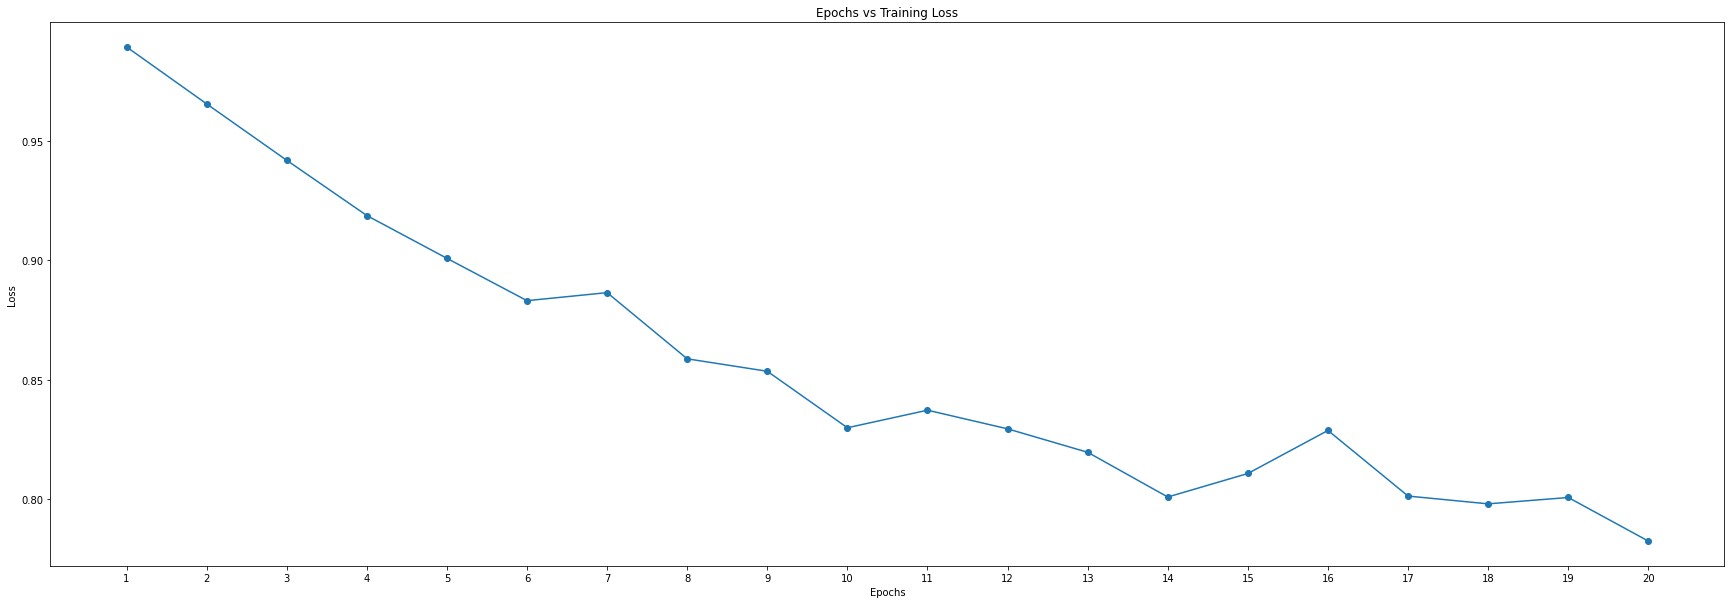

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
accs_fn[0]=acc1
plot_graph(loss_values)

# **2) Contrastive Loss**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,obj.contrastive_loss,RMSprop())

Epoch 1/20
212/212 [==============================] - 2s 5ms/step - loss: 0.0272
Epoch 2/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0269
Epoch 3/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0267
Epoch 4/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0262
Epoch 5/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0256
Epoch 6/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0255
Epoch 7/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0255
Epoch 8/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0244
Epoch 9/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0252
Epoch 10/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0247
Epoch 11/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0242
Epoch 12/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0251
Epoch 13/20
212/212 [====

Accuracy on training data:  99.33856088560886
Accuracy on test data: 96.68350168350169


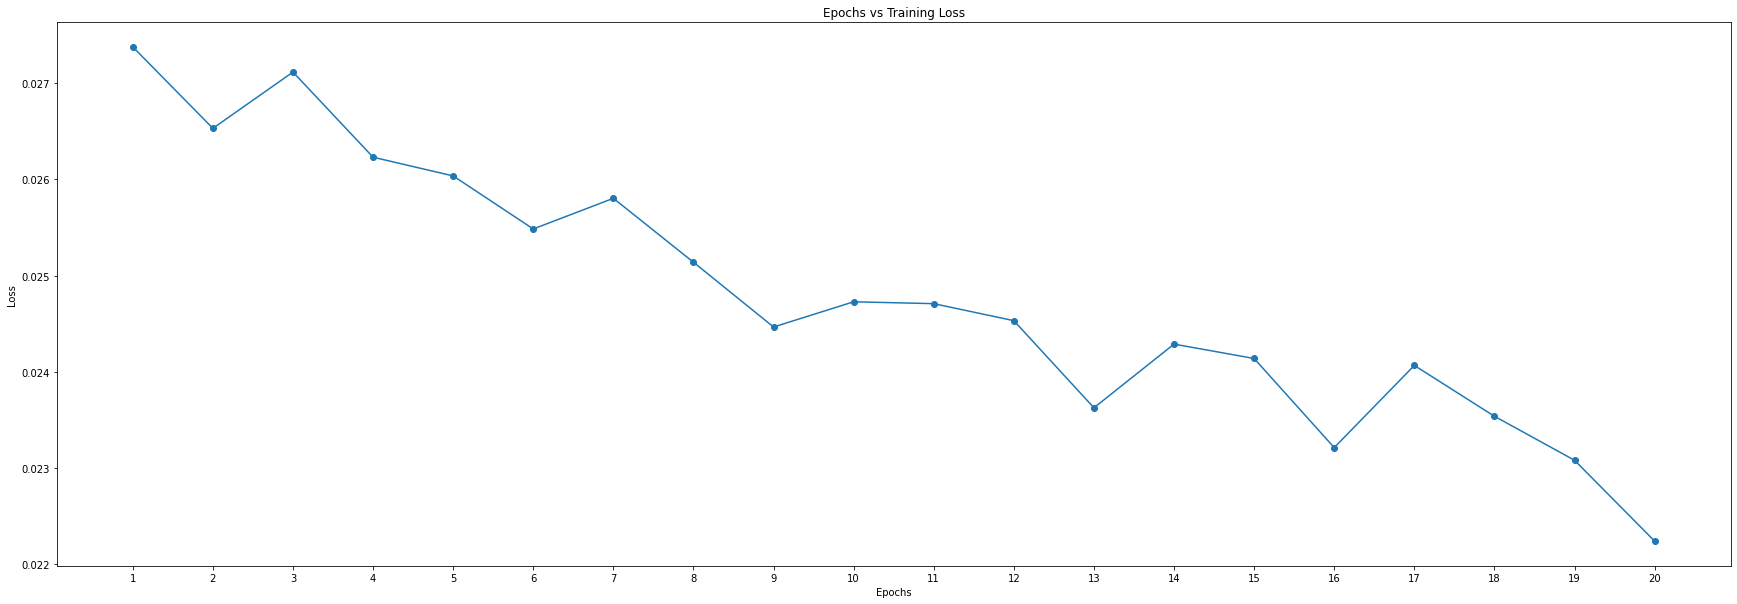

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
plot_graph(loss_values)
accs_fn[1]=acc1

# **3) Regularized Cross Entropy**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,'categorical_crossentropy',RMSprop())

Epoch 1/20
212/212 [==============================] - 2s 5ms/step - loss: 5.9996e-08
Epoch 2/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9560e-08
Epoch 3/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9830e-08
Epoch 4/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9558e-08
Epoch 5/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9270e-08
Epoch 6/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9357e-08
Epoch 7/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9565e-08
Epoch 8/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9459e-08
Epoch 9/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9433e-08
Epoch 10/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9604e-08
Epoch 11/20
212/212 [==============================] - 1s 5ms/step - loss: 5.9609e-08
Epoch 12/20
212/212 [==============================] - 1s 5ms/s

Accuracy on training data:  99.07380073800738
Accuracy on test data: 96.98092031425365


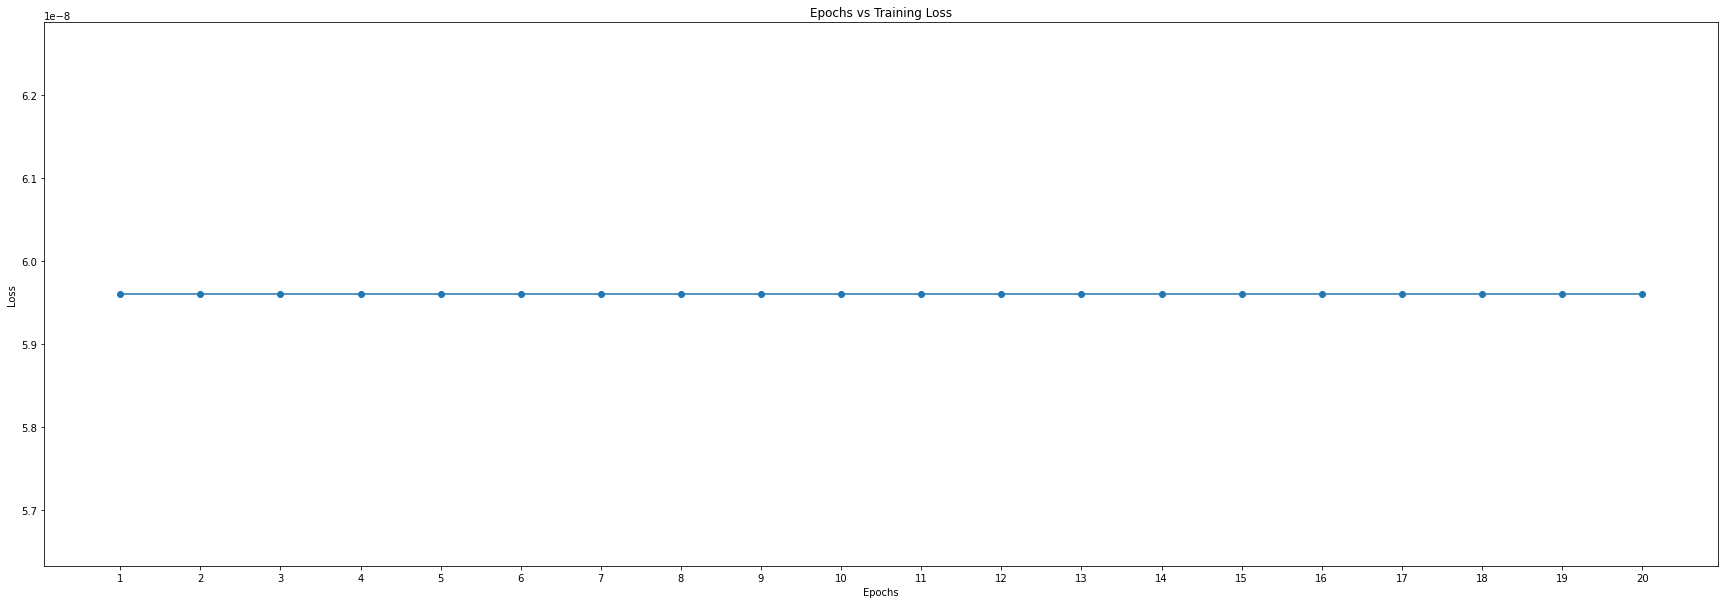

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
plot_graph(loss_values)
accs_fn[2]=acc1

# **Comparison of these 3 loss Functions**

In [ ]:
table = [['Loss Function', 'ACCURACY'], ['Triple Loss',str(accs_fn[0])], ['Contrastive Loss',str(accs_fn[1])], ['Regularized Cross Entropy',str(accs_fn[2])]]

print()
print()
from tabulate import tabulate
print(tabulate(table, headers='firstrow'))



Loss Function                ACCURACY
-------------------------  ----------
Triple Loss                  0.957239
Contrastive Loss             0.966835
Regularized Cross Entropy    0.969809


**Different Optimzers**

In [ ]:
accs_opts = [0,0,0]

# **1) RMSprop Optimizer**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,obj.contrastive_loss,RMSprop())


Epoch 1/20
212/212 [==============================] - 2s 5ms/step - loss: 0.0227
Epoch 2/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0235
Epoch 3/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0227
Epoch 4/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0212
Epoch 5/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0225
Epoch 6/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0216
Epoch 7/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0216
Epoch 8/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0225
Epoch 9/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0207
Epoch 10/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0216
Epoch 11/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0237
Epoch 12/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0213
Epoch 13/20
212/212 [====

Accuracy on training data:  99.43357933579335
Accuracy on test data: 96.69472502805836


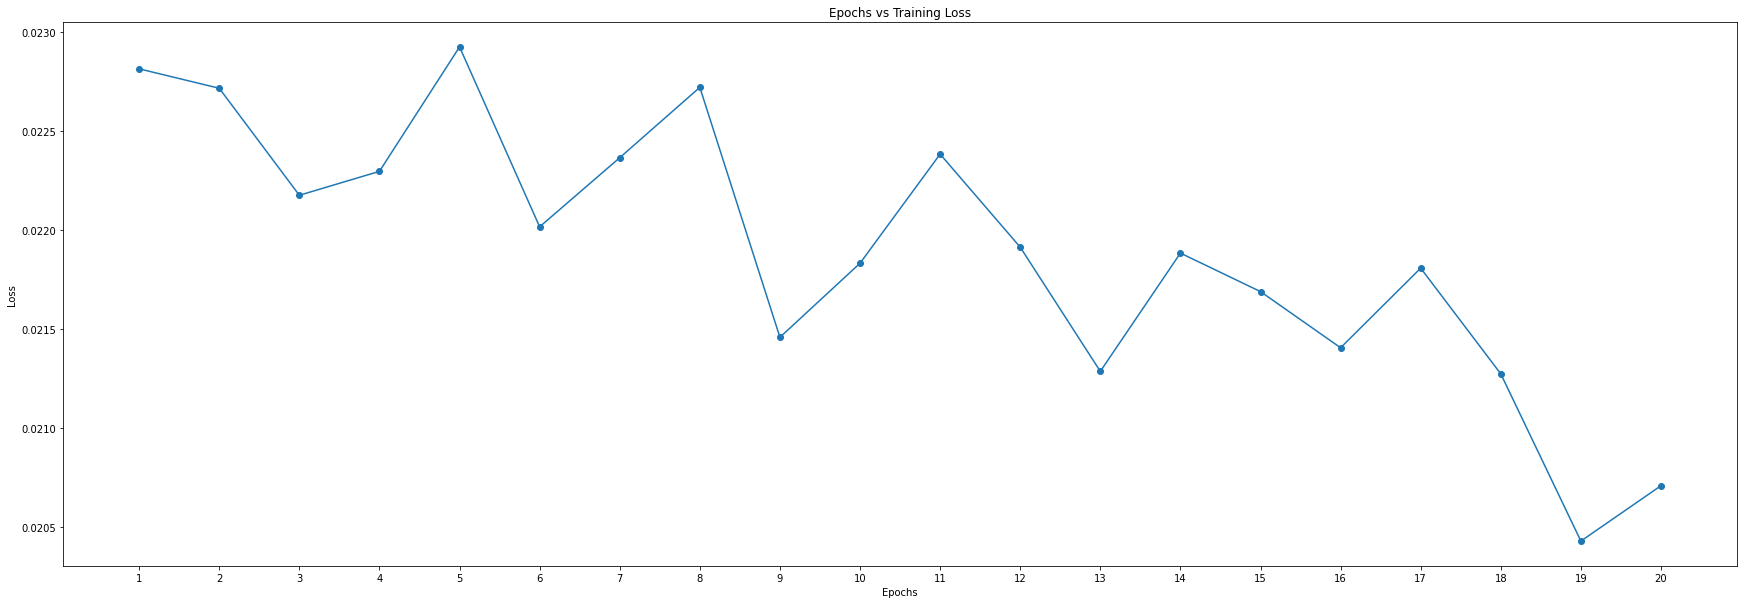

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
plot_graph(loss_values)
accs_opts[0]=acc1

# **2) Adam Optimizer**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,obj.contrastive_loss,Adam(lr=0.001))


Epoch 1/20
212/212 [==============================] - 2s 5ms/step - loss: 0.0218
Epoch 2/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0224
Epoch 3/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0217
Epoch 4/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0221
Epoch 5/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0198
Epoch 6/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0201
Epoch 7/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0209
Epoch 8/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0193
Epoch 9/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0204
Epoch 10/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0211
Epoch 11/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0187
Epoch 12/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0192
Epoch 13/20
212/212 [====

Accuracy on training data:  99.49169741697416
Accuracy on test data: 96.94163860830527


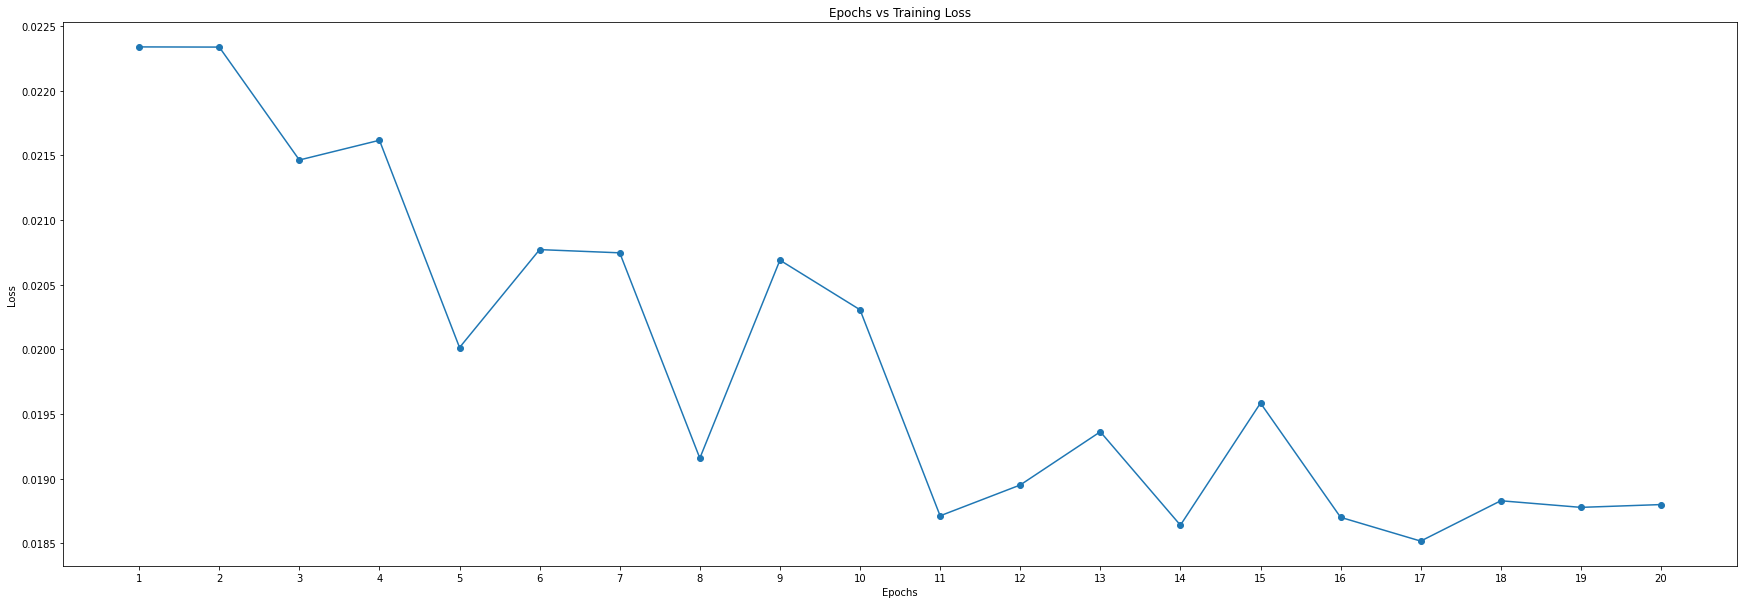

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
plot_graph(loss_values)
accs_opts[1]=acc1

# **3) Mini Batch Gradient Descent**

In [ ]:
history,y_pred_train,y_pred_test=model_call(new,input,train_pair,test_pair,obj.contrastive_loss,SGD(lr = 0.01, decay=1e-6, momentum=0.9 ,nesterov=True))


Epoch 1/20
212/212 [==============================] - 2s 5ms/step - loss: 0.0170
Epoch 2/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0160
Epoch 3/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0153
Epoch 4/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 5/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0144
Epoch 6/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0140
Epoch 7/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0155
Epoch 8/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0146
Epoch 9/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0151
Epoch 10/20
212/212 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 11/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0146
Epoch 12/20
212/212 [==============================] - 1s 5ms/step - loss: 0.0143
Epoch 13/20
212/212 [====

Accuracy on training data:  99.63099630996311
Accuracy on test data: 97.02581369248036


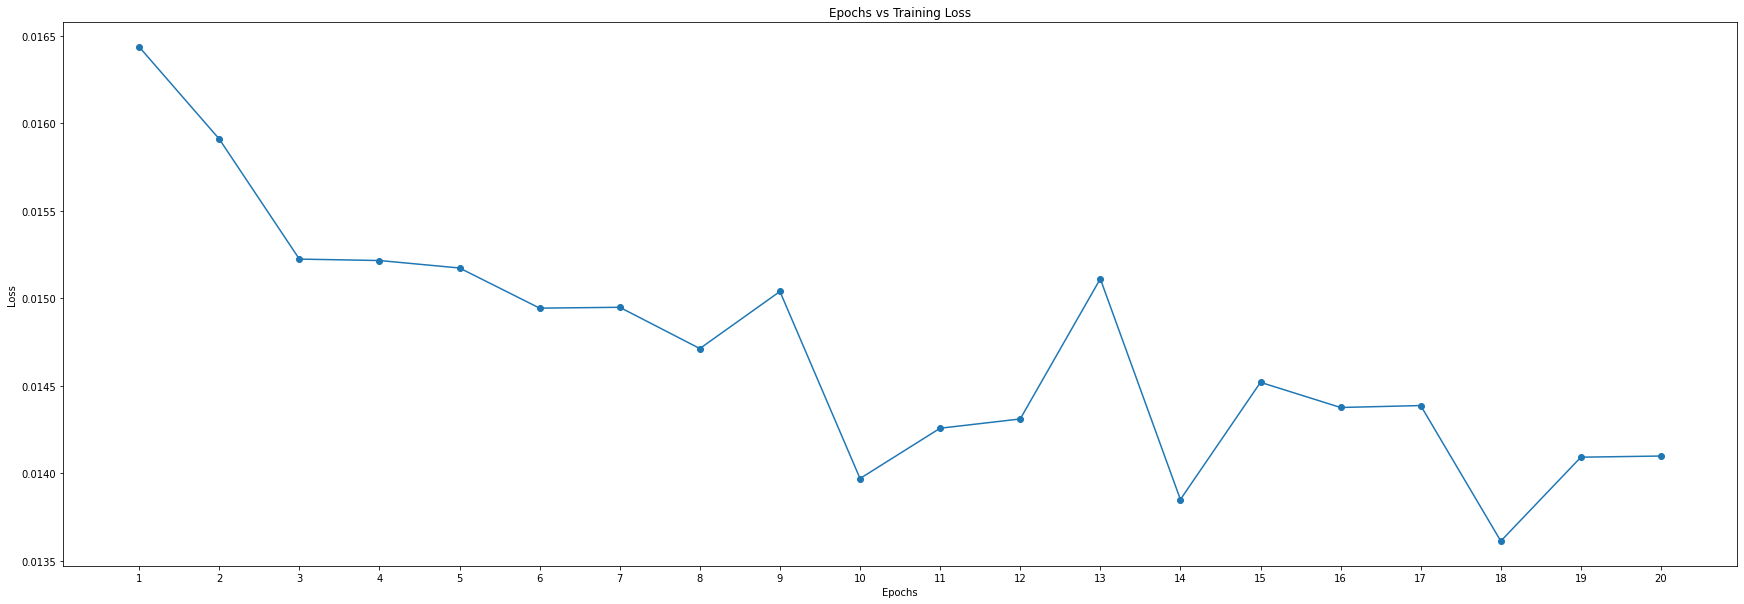

In [ ]:
loss_values,acc1=show_accuracy(train_pair,test_pair,y_pred_train,y_pred_test,history)
plot_graph(loss_values)
accs_opts[1]=acc1

# **Hyper Parameter Tuning**

In [ ]:
distance = Lambda(obj.euclid, output_shape=obj.euclidshape)([new["a"], new["b"]])
model = Model([input["a"], input["b"]], distance)    
model.compile(loss=obj.contrastive_loss, optimizer=Adam(lr=0.01, beta_1=0.9))
history = model.fit([train_pair["X"][:, 0], train_pair["X"][:, 1]], train_pair["Y"], batch_size=64, epochs=20)
y_pred_train = model.predict([train_pair["X"][:, 0], train_pair["X"][:, 1]])
y_pred_test = model.predict([test_pair["X"][:, 0], test_pair["X"][:, 1]])

Epoch 1/20
1694/1694 [==============================] - 6s 3ms/step - loss: 0.0198
Epoch 2/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0193
Epoch 3/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0186
Epoch 4/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0183
Epoch 5/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0177
Epoch 6/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0178
Epoch 7/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0180
Epoch 8/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0172
Epoch 9/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0172
Epoch 10/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0174
Epoch 11/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0163
Epoch 12/20
1694/1694 [==============================] - 5s 3ms/step - loss: 0.0168
E

In [ ]:
train_acc = np.mean((y_pred_train.ravel() < 0.5) == train_pair["Y"])
test_acc =  np.mean((y_pred_test.ravel() < 0.5) == test_pair["Y"])
print('Accuracy on training data: ', (100 * train_acc))
print('Accuracy on test data:', (100 * test_acc))

Accuracy on training data:  99.37638376383764
Accuracy on test data: 97.12682379349046


In [ ]:
print('Hyperparameter Tuned:- Reduced batch size, Changed Learning Rate, Added beta_1 for Adam optimiser')
print('\nAccuracy before tuning = ', accs_opts[1])
print('Accuracy after tuning = ', (100 * test_acc))

Hyperparameter Tuned:- Reduced batch size, Changed Learning Rate, Added beta_1 for Adam optimiser

Accuracy before tuning =  0.9702581369248036
Accuracy after tuning =  97.12682379349046


# Pros and Cons of Siamese Network

## Pros


* Few images per class is sufficient
* Can learn semantic similarity

## Cons



* Slow Training
* Only predict similarities, Doesn’t output probabilities